# Support Vector Machines solver

We are given *m* data points $x_i\in\mathbb{R}^n$ with labels $y_i\in\{-1,1\}$. We want to solve the soft margin SVM classification problem :


\begin{align*}
\text{minimize}&\;\;\;\; \frac{1}{2} \Vert w\Vert_2^2 + C \boldsymbol{1}^Tz\\
\text{subject to}&\;\;\;\; y_i(w^Tx_i) \ge 1 - z_i,\:\:\: i=1,\dots,m \\
&\;\;\;\;  z \ge 0
\end{align*}

The variables are $w$ and $z$ (the soft margin value), and $C$ is a constant coefficient to value more or less the soft margin.


## Implementation

We use the barrier method to solve this problem. Weights $w$ are initialized randomly, and the $z$ is inialized accordingly to have a feasible solution. Gradients and Hessian are computed with basic formulas over logarithmic barrier.

Note that we can recover the solution of the dual problem thanks to the fact that the point $\lambda(t)$ defined by $\lambda_i(t)=\frac{1}{-tf_i(x^*(t))}$ is a dual feasible point. Moreover $g(\lambda(t)) = f_0(x^*(t)) - \frac{m}{t}$ so $\lambda(t)$ will indeed converge toward the dual solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.svm import SVC

In [117]:
def NewtonMethod(f,grad,hess,x0,eps=1e-5,alpha=0.25,beta=0.5,record_history=False):
    """
    Apply Newton Method for an unconstrained convex optimization problem
    
    Arguments:
    f (func): objective function
    grad (func): objective function gradient
    hess (func): objective function hessian
    x0 (numpy.ndarray): initization point
    
    Returns:
    (solution, history) : if record_history is set to True
    solution : otherwise
    """
    x = x0
    newton_decr_squared = eps
    history = []
    while True:
        history.append(x.tolist())
        G = grad(x)
        H = hess(x)
        newton_step = np.linalg.solve(H,-G)
        newton_decr_squared = -np.dot(newton_step,G)
        if newton_decr_squared/2 < eps:
            return x,history
        t_backtrack = 1.
        while (f(x+t_backtrack*newton_step) > f(x) + alpha*t_backtrack*np.dot(newton_step,G)):
            t_backtrack *= beta
        x += t_backtrack*newton_step    

def BarrierMethod(obj_f,obj_grad,obj_hess,log_barrier_f,log_barrier_grad,log_barrier_hess,x0,n_constr,t0=1,mu=10,eps=1e-5,record_history=False):
    """
    Apply the barrier method for inequality constrained convex optimization problem.
    The inequality constraints arguments should already be in the negative log barrier form,
    the function ... can automatically transform the constraints into this form.
    
    Returns:
    (primal_solution, dual_solution)
    """
    t = t0/mu
    x = x0
    m = n_constr
    history = []
    while m/t >= eps:
        t *= mu
        current_f = lambda x : t*obj_f(x) + log_barrier_f(x)
        current_f_grad = lambda x : t*obj_grad(x) + log_barrier_grad(x)
        current_f_hess = lambda x : t*obj_hess(x) + log_barrier_hess(x)
        x,hist = NewtonMethod(current_f, current_f_grad, current_f_hess, x)
        history += hist
    dual = t # we return t for the dual because we can recover the dual solution from it
    if record_history:
        return (x,dual,history)
    else:
        return (x,dual)

def log_barrier_functions(f_i,grad_f_i,hess_f_i):
    """
    Transform the constraints functions f_i into their logarithmic barrier terms
    
    Arguments:
    f_i (func list): list of constraints functions which must satisfy f_i <= 0
    grad_f_i (func list): list of constraints gradients functions
    hess_f_i (func list): list of constraints hessian functions
    
    Returns:
    (log_barrier_f, log_barrier_grad, log_barrier_hess) (func tuple)
    """
    n = len(f_i)
    
    def log_barrier_f(x):
        s = 0
        for f in f_i:
            if f(x) > 0:
                s += math.inf
            else:
                s -= np.log(-f(x))
        return s
    
    def log_barrier_grad(x):
        s = np.zeros(grad_f_i[0](x).shape)
        for i in range(n):
            s -= grad_f_i[i](x)/(f_i[i](x))
        return s
    
    def log_barrier_hess(x):
        m = hess_f_i[0](x).shape[0]
        s = np.zeros((m,m))
        for i in range(n):
            s -= hess_f_i[i](x)/(f_i[i](x))
        for i in range(n):
            g = np.expand_dims(grad_f_i[i](x),1)
            s += np.dot(g,g.T)/(f_i[i](x)**2)
        return s
    
    return log_barrier_f, log_barrier_grad, log_barrier_hess

In [80]:
class SVM():
    def __init__(self,c=1,bias=False):
        """
        Arguments:
        c (int): hyperparameter to tune the soft margin
        bias (boolean): adds a bias to the classification
        """
        self.C = c
        self.bias = bias
    
    def fit(self,X,y):
        # define datas
        self.X = X
        if self.bias:
            self.X = np.concatenate((self.X,np.ones((X.shape[0],1))),axis=1)
        self.y = y
        self.n = self.X.shape[1]
        self.m = self.X.shape[0]
        
        # define functions
        f,f_grad,f_hess = self.log_barrier_functions()
        objective_function = lambda x: (np.linalg.norm(x[:self.n])**2)/2. + self.C*np.sum(x[self.n:])
        def grad(x):
            output = np.copy(x)
            output[self.n:] = self.C
            return output
        objective_function_grad = grad
        objective_function_hess = lambda x: np.diag(np.concatenate((np.ones(self.n),np.zeros(self.m))))
        x0 = self.generate_feasible()
        
        # optimize to find the parameters
        primal, dual, history = BarrierMethod(objective_function,objective_function_grad,objective_function_hess,
                                     f,f_grad,f_hess,x0,n_constr=2*self.m,record_history=True)
        
        self.w = primal[:self.n]
        self.z = primal[self.n:]
        
        objective_history = list(map(objective_function, np.array(history)))
        self.primal_gap = objective_history - np.amin(objective_history)
        
    def predict(self,X):
        if self.bias:
            X_biased = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
            return np.sign(np.dot(X_biased,self.w))
        else:
            return np.sign(np.dot(X,self.w))

    def generate_feasible(self):
        w = np.random.randn(self.n)
        z = 2+np.amax(np.abs(np.dot(self.X,w)))*np.ones(self.m)
        return np.concatenate((w,z))
    
    def log_barrier_functions(self):
        f_i, grad_f_i, hess_f_i = [],[],[]
        for i in range(self.m):
            f,grad,hess = self.soft_margin_constraint(i)
            f_i.append(f)
            grad_f_i.append(grad)
            hess_f_i.append(hess)
        for i in range(self.m):
            f,grad,hess = self.positive_constraint(i)
            f_i.append(f)
            grad_f_i.append(grad)
            hess_f_i.append(hess)
        log_barrier_f, log_barrier_grad, log_barrier_hess = log_barrier_functions(f_i,grad_f_i,hess_f_i)
        return (log_barrier_f, log_barrier_grad, log_barrier_hess)
    
    def soft_margin_constraint(self,i):
        def f(inpt):
            w = inpt[:self.n]
            z = inpt[self.n:]
            return 1-z[i]-self.y[i]*np.dot(self.X[i],w)
        def grad(inpt):
            w = inpt[:self.n]
            z = inpt[self.n:]
            output = np.zeros(inpt.shape)
            output[:self.n] = -self.y[i]*self.X[i]
            output[self.n:][i] = -1
            return output
        def hess(inpt):
            return np.zeros(inpt.shape)
        return f,grad,hess
    
    def positive_constraint(self,i):
        def f(inpt):
            z = inpt[self.n:]
            return -z[i]
        def grad(inpt):
            output = np.zeros(inpt.shape)
            output[self.n:][i] = -1
            return output
        def hess(inpt):
            return np.zeros(inpt.shape)
        return f,grad,hess

## Experiments

Now we generate datas, plot them, and test our SVM on them. 

In [4]:
def generate_2Ddata(n,mean1,mean2,std1,std2):
    X1 = np.random.normal(size=(n,2),loc=mean1,scale=std1)
    X2 = np.random.normal(size=(n,2),loc=mean2,scale=std2)
    Y1 = np.ones(n)
    Y2 = -np.ones(n)
    return np.concatenate((X1,X2)),np.concatenate((Y1,Y2))

def visualize_data(X,y):
    plt.scatter(X[:,0],X[:,1],c=y,cmap='Paired')

def plot_boundary(X,y,model,model_w=None,model_bias=None):
    # plot contour map
    x0_min, x0_max = np.amin(X[:,0])-1, np.amax(X[:,0])+1
    x1_min, x1_max = np.amin(X[:,1])-1, np.amax(X[:,1])+1
    x0_grid = np.arange(x0_min, x0_max, 0.01)
    x1_grid = np.arange(x1_min, x1_max, 0.01)
    xx, yy = np.meshgrid(x0_grid, x1_grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    grid_pred = model.predict(grid)
    zz = grid_pred.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired', alpha=.3)
    
    # plot margin
    if (model_w is not None) and (model_bias is not None):
        middle_y = (-model_w[0]*x0_grid-model_bias)/model_w[1]
        bottom_y = (1-model_w[0]*x0_grid-model_bias)/model_w[1]
        top_y = (-1-model_w[0]*x0_grid-model_bias)/model_w[1]
        plt.plot(x0_grid,middle_y,color='red')
        plt.plot(x0_grid,bottom_y,color='blue')
        plt.plot(x0_grid,top_y,color='blue')
    
    plt.scatter(X[:,0],X[:,1],c=y, cmap='Paired')
    plt.xlim([x0_min,x0_max])
    plt.ylim([x1_min,x1_max])


### Choice of C

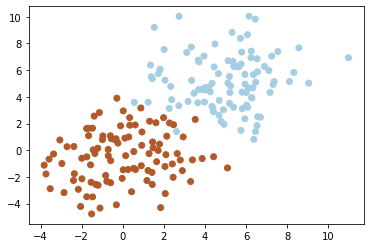

In [128]:
X,y = generate_2Ddata(100,(0,0),(5,5),(2,2),(2,2))
visualize_data(X,y)
plt.show()

In [129]:
svm1 = SVM(bias=True,c=0.25)
svm1.fit(X,y)
svm2 = SVM(bias=True,c=1.)
svm2.fit(X,y)
svm3 = SVM(bias=True,c=4.)
svm3.fit(X,y)

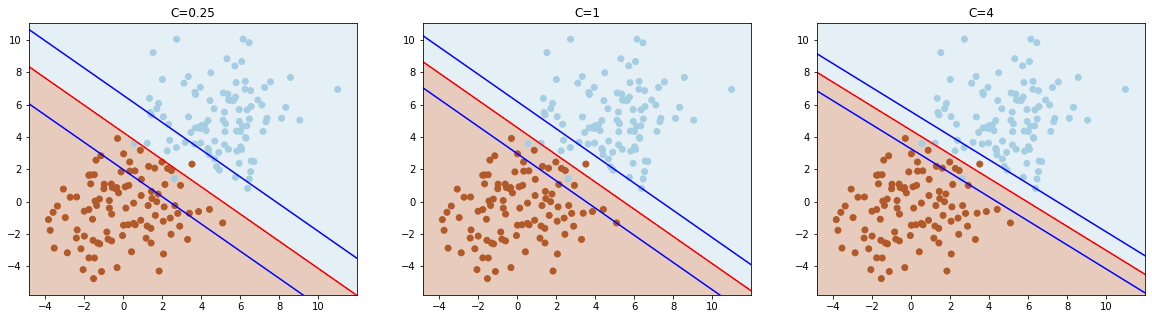

In [130]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1, title='C=0.25')
plot_boundary(X,y,svm1,svm1.w[:2],svm1.w[2])
plt.subplot(1, 3, 2, title='C=1')
plot_boundary(X,y,svm2,svm2.w[:2],svm2.w[2])
plt.subplot(1, 3, 3, title='C=4')
plot_boundary(X,y,svm3,svm3.w[:2],svm3.w[2])
plt.show()

Indeed, the higher the $C$ factor is, the tigher are the margins.

### Plot of separation boundary

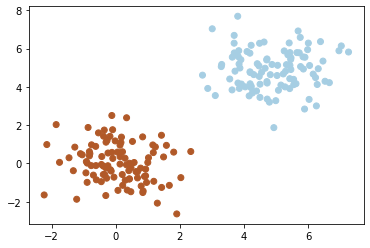

In [133]:
X,y = generate_2Ddata(100,(0,0),(5,5),(1,1),(1,1))
visualize_data(X,y)
plt.show()

We compare our implementation of SVM to the scikit-learn one.

In [134]:
svm = SVM(bias=True)
svm.fit(X,y)

sklearn_svm = SVC(kernel='linear')
sklearn_svm.fit(X,y)

SVC(kernel='linear')

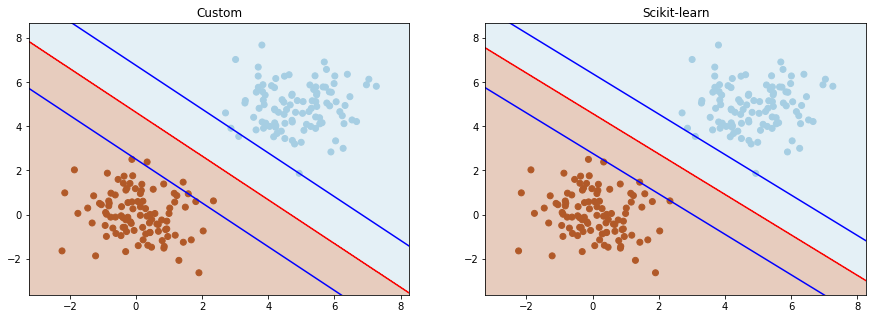

In [135]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1, title='Custom')
plot_boundary(X,y,svm,svm.w[:2],svm.w[2])
plt.subplot(1, 2, 2, title='Scikit-learn')
plot_boundary(X,y,sklearn_svm,sklearn_svm.coef_[0],sklearn_svm.intercept_)

When the data points are well separated, the SVM indeed finds a separation which optimize the margin.

We display the primal gap $f(x_k)-f_*$

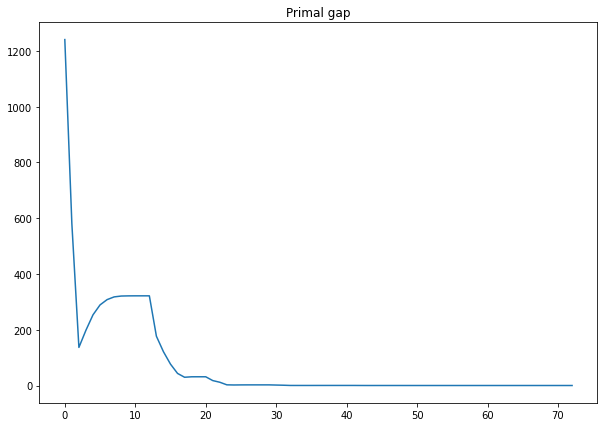

In [136]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1, title='Primal gap')
plt.plot(svm.primal_gap)
plt.show()

Finally, we test it on a less simple example (where soft margins are required).

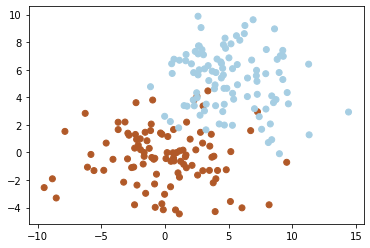

In [179]:
X,y = generate_2Ddata(100,(0,0),(5,5),(4,2),(3,2))
visualize_data(X,y)
plt.show()

In [180]:
svm = SVM(bias=True)
svm.fit(X,y)

sklearn_svm = SVC(kernel='linear')
sklearn_svm.fit(X,y)

SVC(kernel='linear')

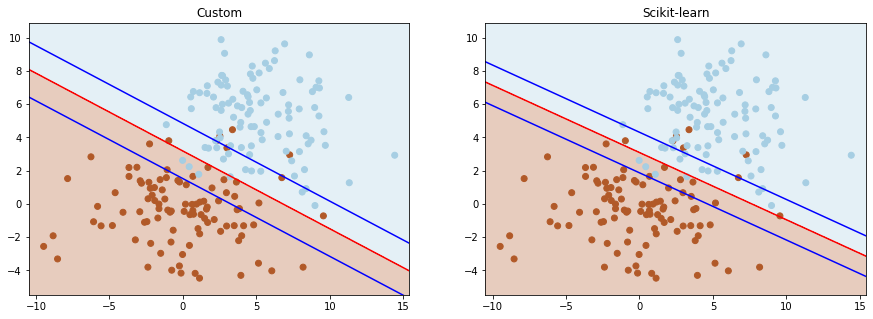

In [181]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1, title='Custom')
plot_boundary(X,y,svm,svm.w[:2],svm.w[2])
plt.subplot(1, 2, 2, title='Scikit-learn')
plot_boundary(X,y,sklearn_svm,sklearn_svm.coef_[0],sklearn_svm.intercept_)

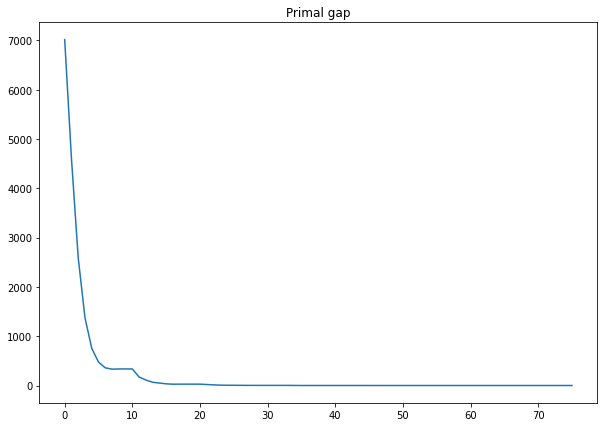

In [182]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1, title='Primal gap')
plt.plot(svm.primal_gap)
plt.show()